In [36]:
import pickle
from plotting import *


In [37]:
##
# Reproduce Mia's results
number_base_sequences = 2
number_hidden_units = 20
number_epochs = 1000

fname = f'{number_base_sequences}seqs_{number_hidden_units}_{number_epochs}'

for len_seq in range(1,4):
        fname = f'{len_seq}{fname[1:]}'
        with open(f'results/{fname}_losses.pkl', 'rb') as f:
            data = pickle.load(f)


1seqs_20_1000
2seqs_20_1000
3seqs_20_1000


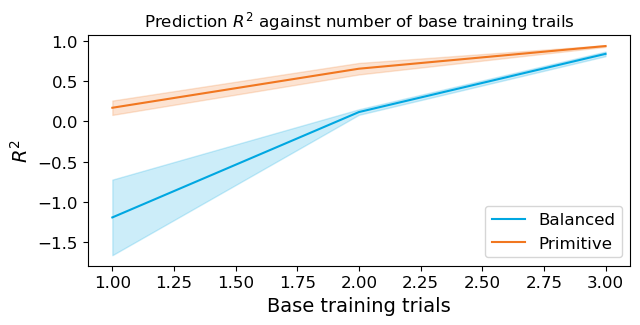

In [38]:
##
# "At low numbers of base training sequences, the Primitive group performed significantly better than the Balanced"
#plot_rmse_setsize(fname)


def get_ground_truth_correlation(models, config, cond = 'final_mod_b'):
    all_r2 = []
    n_sims = len(models[cond])
    for ix, model_dict in enumerate(models[cond]):
        model = OneStepRNN(config['input_size'], config['output_size'], 
                        config['hidden_size'], config['num_layers'], config['xavier_gain'])
        model.load_state_dict(model_dict)

        df = test_preds(model, [models['test'][ix]], config['hidden_size'])
        all_r2.append(r2_score(df['pred'],df['label']))

    r2_mean = np.mean(all_r2)
    r2_sterr = np.std(all_r2)/math.sqrt(n_sims)

    return r2_mean, r2_sterr

vals = np.empty((0,4))
for len_seq in range(1,4):

    #load model
    fname = f'{len_seq}{fname[1:]}'
    print(fname)
    d_models = torch.load(f'results/{fname}_modelonly.pt')
    config = d_models['config_model']

    #correlate predictions with gorund truth
    r2_b, sterr_b = get_ground_truth_correlation(d_models, config, cond = 'final_mod_b')
    r2_p, sterr_p = get_ground_truth_correlation(d_models, config, cond = 'final_mod_p')

    #collect across set sizes
    set_vals = [r2_b, r2_p, sterr_b, sterr_p]
    vals = np.vstack([vals, set_vals])

#plot
j = 0
labels = ['Balanced','Primitive']
colors = ['#00A7E1', '#F17720']
plt.figure(figsize = (7,3))
xpos = np.arange(1, vals.shape[0]+1)
Nn = int(vals.shape[1]/2)
for j in range(Nn):
    plt.plot(xpos, vals[:,j], label = labels[j], color=colors[j])
    plt.fill_between(xpos, vals[:,j] + vals[:,j+Nn], vals[:,j] - vals[:,j+Nn], color=colors[j], alpha=0.2)
plt.legend(loc='lower right')
plt.xlabel('Base training trials')
plt.ylabel('$R^2$')
plt.title('Prediction $R^2$ against number of base training trails')
plt.show()

In [42]:

# Continue with 2 base sequences
number_base_sequences = 2
number_hidden_units = 1
number_epochs = 500
fname = f'{number_base_sequences}seqs_{number_hidden_units}_{number_epochs}'
# read in models & losses
d_models = torch.load(f'results/{fname}_modelonly.pt')
config_model = d_models['config_model']

with open(f'results/{fname}_losses.pkl', 'rb') as f:
    data = pickle.load(f)


In [43]:
# Complementing 2 base sequences with primitive mappings (Primitive) 
# or 2 additional sequences that result in the same overall frequency per input symbol (Balanced)
# Primitive pre-training results in better performance than Balanced pre-training

#plot_predcorr(config_model, fname, d_models['final_mod_b'], d_models['test'], config_model, title = 'final model - ', cond = 'b')
#plot_predcorr(config_model, fname, d_models['final_mod_p'], d_models['test'], config_model, title = 'finalmodel - ',  cond = 'p')

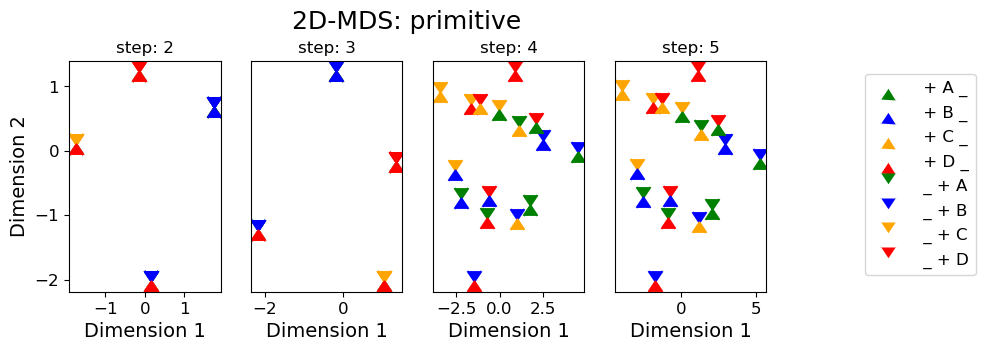

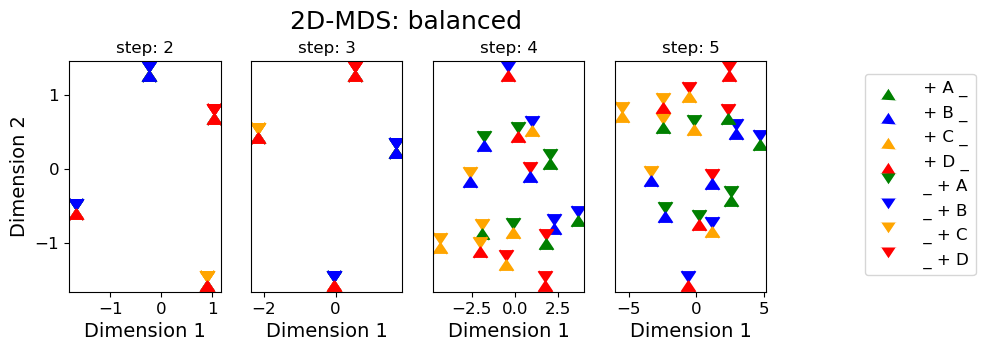

In [44]:
# In terms of geometry of the hidden unit activations
# After primitive pre-training the representation if more grid-like compared to balanced pre-training
matlist, testset = get_hidden_reps(d_models, config_model, 'final_mod_p')
MDS_plot(fname, matlist, testset, [], MDStype = 'MDS', rand_state=48, affix='p')
    
matlist, testset = get_hidden_reps(d_models, config_model, 'final_mod_b')
MDS_plot(fname, matlist, testset, [], MDStype = 'MDS', rand_state=48, affix = 'b')
